# New section

In [16]:
# Load required packages
import pandas as pd
import re # to extract info according to pattern
import seaborn as sns
import matplotlib.pyplot as plt
import glob # sort files
import xml.etree.ElementTree as ET # parse to xml file
import xml.etree.ElementTree as etree
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')  # Ensure the punkt tokenizer models are downloaded
nltk.download('stopwords')  # Ensure the stopwords are downloaded
nltk.download('wordnet')

In [6]:
# multiple files with "review__.txt' named.
%cd datasets
file_pattern = "review_*.txt"
file_names = glob.glob(file_pattern)
file_names.sort() # sort in alphabetical order

/content/datasets


In [7]:
# define regex patterns to extract particular information from the users
rev_id, prod_id, rev_name, no_help, rev_date, rev_text, summary = ([] for i in range (7))

 # regex patterns
rev_id_pattern = r"^\$(rev|reviewer)[id_.\:]+\s[A-Z0-9]+$"
prod_id_pattern = r"^\$(prod|product)[id_.\:]+\s[A-Z0-9]+$"
rev_name_pattern = r"^\$(rev|reviewer)[name_.:]+\s.*$"
no_help_pattern = r"^\$(helps|Helpful|No\. helps)[.\?_]+:\s[\[0-9\,\s\]]+"
date_pattern = r"\$(reviewDate|review_date)[.:]+\s(?:[0-1][0-9]\s[0-9]+\,\s[2][0][0-2][0-9])+"
text_pattern = r"\$(?:REVIEW|review)[text_.:]+\s([\s\S]*?)(?=\$\w+\.:)"
summary_pattern = r"\$(?:review_summary|SUMMARY)[.:]+\s([\s\S]*?)(?=\$(?:rev|[a-zA-Z])\w+|$)"


patterns = {rev_id_pattern: rev_id,
            prod_id_pattern: prod_id,
            rev_name_pattern: rev_name,
            no_help_pattern: no_help,
            date_pattern: rev_date,
}


In [8]:
# opening the review txt files and extract information according to the patterns
def pattern_extract(pattern, line, target_list): # defined funct tion extract each matching attribute and append to the list
  match = re.search(pattern, line, re.IGNORECASE)
  if match:
    match_part = match.group().strip()
    target_list.append(match_part)

for reviews in file_names:
  with open(reviews, "r") as file:
    file_content = file.read() # review text and summary in separate method since we are dealing with multiple/lines.
    rev_text.extend(re.findall(text_pattern, file_content))
    summary.extend(re.findall(summary_pattern, file_content))
    file.seek(0) # reset file pointer for to initiate line-by-line extraction of each pattern

    for line in file:
        for pattern, target_list in patterns.items():
                pattern_extract(pattern, line, target_list)


# test
rev_text[0]

"This card works as expected, was delivered fast and for a great price. The card doesn't run much but as long as i got picture i was happy!\n"

In [9]:
# map column names to their lists.
columns = {
    'reviewer_id': rev_id,
    'reviewer_name': rev_name,
    'productID': prod_id,
    'review_helpful': no_help,
    'Date': rev_date,
    'review_text': [text.strip() for text in rev_text],
    'review_summary': [summary.strip() for summary in summary]}  # strip white spaces for text and summary.

# created dictionary to create a dataframe for each column.
df_dict = {key: pd.DataFrame({key: value}) for key, value in columns.items()}
combine_df = pd.concat(df_dict.values(), axis=1) # combine each column together to form a dataframe.
# test
combine_df.head()# printing out the first 5 and last 5 to determine each row is unique (right information)!
# print(combine_df.tail())

,reviewer_id,reviewer_name,productID,review_helpful,Date,review_text,review_summary
0,$rev_ID.: A1BWD4UA5QTBOI,$reviewerName.: Edward Popp,$productID.: B004BQKQ8A,"$Helpful?.: [0, 0]","$reviewDate.: 10 28, 2013","This card works as expected, was delivered fas...",Bought this for an older computer.
1,$rev_ID.: A27JB8ALUWAECO,$reviewer.NAME.: Hector M. Lugo,$productID.: B005O74J7O,"$No. helps.: [0, 0]","$reviewDate.: 01 16, 2014","Well, as cases go, this one looks good on the ...","No, just no!"
2,$rev_ID.: A32B6A532454UD,"$rev_NAME.: D. Taylor ""Tech Gadget User""",$product.ID.: B005P9CATU,"$No. helps.: [10, 10]","$reviewDate.: 06 12, 2012",I've been using these APP or Anderson Power Po...,"Reliable connector, considered standard in Ham..."
3,$reviewerID.: A225M3GAYN01IG,$rev_NAME.: buster_roo,$productID.: B0023APPCI,"$No. helps.: [1, 1]","$review_date.: 04 10, 2011",I have this model. I use it with my Vizio LED...,"great sound, easy set up, looks amazing"
4,$rev_ID.: AX2F72W2O86WI,$reviewerName.: Alyx,$productID.: B0055LGG3Y,"$No. helps.: [3, 4]","$review_date.: 06 7, 2012",If you're building a system using SandyBridge ...,Great Memory


In [11]:
def xml_characters(text): # function to deal with xml characters
    return re.sub(r'[<>&\'"]', ' ', text)

def xml_parser(combine_df):
    root = ET.Element("users")
    for index, row in combine_df.iterrows():
        user_element = ET.SubElement(root, "user", name=row['reviewer_id'])
        ET.SubElement(user_element, 'latest_review_date').text = row['Date']
        reviews_element = ET.SubElement(user_element, 'reviews')
        review_element = ET.SubElement(reviews_element, 'review')
        ET.SubElement(review_element, 'productID').text = row['productID']
        ET.SubElement(review_element, 'review_date').text = row['Date']
        ET.SubElement(review_element, 'review_helpful').text = str(row['review_helpful'])
        ET.SubElement(review_element, 'review_text').text = xml_characters(row['review_text'])
        ET.SubElement(review_element, 'review_summary').text = xml_characters(row['review_summary'])

    tree = ET.ElementTree(root)
    tree.write('amazon-customer-reviews.xml') # output file save

xml_parser(combine_df)


In [41]:
file_path = "amazon-customer-reviews.xml"

def clean_text(text):
    # Function to clean text by removing unwanted prefixes and formatting
    if text is not None:
        # Assuming prefixes end with a colon and possibly a period, adjust as necessary
        return text.split('.: ')[-1]
    return None

def parse_xml_optimized(file_path):
    # Parse the XML file
    tree = ET.parse(file_path)
    root = tree.getroot()

    # Use list comprehension to collect all reviews data, with text cleaning
    reviews_data = [{
        "userID": clean_text(user.get('name')),
        "review_date": clean_text(user.findtext('latest_review_date')),
        "productID": clean_text(review.findtext('productID')),
        "review_helpful": clean_text(review.findtext('review_helpful')),
        "review_text": clean_text(review.findtext('review_text')),
        "review_summary": clean_text(review.findtext('review_summary'))
    } for user in root.findall('user') for review in user.find('reviews')]

    # Convert the list to a DataFrame
    return pd.DataFrame(reviews_data)

review_df = parse_xml_optimized(file_path)
review_df.head()

,userID,review_date,productID,review_helpful,review_text,review_summary
0,A1BWD4UA5QTBOI,"10 28, 2013",B004BQKQ8A,"[0, 0]","This card works as expected, was delivered fas...",Bought this for an older computer.
1,A27JB8ALUWAECO,"01 16, 2014",B005O74J7O,"[0, 0]","Well, as cases go, this one looks good on the ...","No, just no!"
2,A32B6A532454UD,"06 12, 2012",B005P9CATU,"[10, 10]",I ve been using these APP or Anderson Power Po...,"Reliable connector, considered standard in Ham..."
3,A225M3GAYN01IG,"04 10, 2011",B0023APPCI,"[1, 1]",I have this model. I use it with my Vizio LED...,"great sound, easy set up, looks amazing"
4,AX2F72W2O86WI,"06 7, 2012",B0055LGG3Y,"[3, 4]",If you re building a system using SandyBridge ...,Great Memory


  NLP

In [42]:
# Mutate date format and convert text and summary reviews to lower cases.
review_df['review_date'] = pd.to_datetime(review_df['review_date'])
review_df['review_text'] = review_df['review_text'].str.lower()
review_df['review_summary'] = review_df['review_summary'].str.lower()
review_df.head()


,userID,review_date,productID,review_helpful,review_text,review_summary
0,A1BWD4UA5QTBOI,2013-10-28,B004BQKQ8A,"[0, 0]","this card works as expected, was delivered fas...",bought this for an older computer.
1,A27JB8ALUWAECO,2014-01-16,B005O74J7O,"[0, 0]","well, as cases go, this one looks good on the ...","no, just no!"
2,A32B6A532454UD,2012-06-12,B005P9CATU,"[10, 10]",i ve been using these app or anderson power po...,"reliable connector, considered standard in ham..."
3,A225M3GAYN01IG,2011-04-10,B0023APPCI,"[1, 1]",i have this model. i use it with my vizio led...,"great sound, easy set up, looks amazing"
4,AX2F72W2O86WI,2012-06-07,B0055LGG3Y,"[3, 4]",if you re building a system using sandybridge ...,great memory


In [43]:
# remove punctuation
string.punctuation
def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree
#storing the puntuation free text
review_df['review_text']= review_df['review_text'].apply(lambda x:remove_punctuation(x))
review_df['review_summary']= review_df['review_summary'].apply(lambda x:remove_punctuation(x))
review_df.head()

,userID,review_date,productID,review_helpful,review_text,review_summary
0,A1BWD4UA5QTBOI,2013-10-28,B004BQKQ8A,"[0, 0]",this card works as expected was delivered fast...,bought this for an older computer
1,A27JB8ALUWAECO,2014-01-16,B005O74J7O,"[0, 0]",well as cases go this one looks good on the ta...,no just no
2,A32B6A532454UD,2012-06-12,B005P9CATU,"[10, 10]",i ve been using these app or anderson power po...,reliable connector considered standard in ham ...
3,A225M3GAYN01IG,2011-04-10,B0023APPCI,"[1, 1]",i have this model i use it with my vizio led ...,great sound easy set up looks amazing
4,AX2F72W2O86WI,2012-06-07,B0055LGG3Y,"[3, 4]",if you re building a system using sandybridge ...,great memory


Removing stopwords and lemmatizing the text into tokens

In [44]:
# Convert review text and summary to string and tokenize
review_df['review_text'] = review_df['review_text'].apply(lambda x: word_tokenize(str(x)))
eng_stopwords = stopwords.words('english')
review_df['review_text'] = review_df['review_text'].apply(lambda words: [word for word in words if word not in eng_stopwords])
review_df['review_summary'] = review_df['review_summary'].apply(lambda x: word_tokenize(str(x)))
review_df['review_summary'] = review_df['review_summary'].apply(lambda words: [word for word in words if word not in eng_stopwords])

# Lemmatization
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(word_list):
    return [lemmatizer.lemmatize(w) for w in word_list]

# Apply the lemmatization function to the 'review_text' and 'review_summary' columns
review_df['review_text'] = review_df['review_text'].apply(lemmatize_text)
review_df['review_summary'] = review_df['review_summary'].apply(lemmatize_text)

# Show the head of the modified DataFrame
review_df.head()


,userID,review_date,productID,review_helpful,review_text,review_summary
0,A1BWD4UA5QTBOI,2013-10-28,B004BQKQ8A,"[0, 0]","[card, work, expected, delivered, fast, great,...","[bought, older, computer]"
1,A27JB8ALUWAECO,2014-01-16,B005O74J7O,"[0, 0]","[well, case, go, one, look, good, tablet, feel...",[]
2,A32B6A532454UD,2012-06-12,B005P9CATU,"[10, 10]","[using, app, anderson, power, pole, connector,...","[reliable, connector, considered, standard, ha..."
3,A225M3GAYN01IG,2011-04-10,B0023APPCI,"[1, 1]","[model, use, vizio, led, hd, tv, vizion, blura...","[great, sound, easy, set, look, amazing]"
4,AX2F72W2O86WI,2012-06-07,B0055LGG3Y,"[3, 4]","[building, system, using, sandybridge, intel, ...","[great, memory]"


In [49]:
# Tokenizing into n-grams
review_text_cv = review_df['review_text'].astype(str)
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r"[A-Za-z]\w+(?:[-'?]\w+)?")
unigram = []
for abstract in review_text_cv:
    unigram_tokens = tokenizer.tokenize(abstract)
    unigram.append(unigram_tokens)
from itertools import chain # this is to combine the lists into single list
words = list(chain.from_iterable(unigram)) # raw token version
unigram[0]

['card',
 'work',
 'expected',
 'delivered',
 'fast',
 'great',
 'price',
 'card',
 'run',
 'much',
 'long',
 'got',
 'picture',
 'happy']

In [51]:
words[:10]

['card',
 'work',
 'expected',
 'delivered',
 'fast',
 'great',
 'price',
 'card',
 'run',
 'much']

[('one', 4281), ('work', 3761), ('use', 3503), ('great', 3288), ('good', 3137), ('like', 3007), ('get', 2904), ('would', 2736), ('camera', 2460), ('well', 2337), ('case', 2226), ('time', 2180), ('cable', 2081), ('sound', 2059), ('also', 1943), ('quality', 1911), ('product', 1815), ('need', 1801), ('really', 1800), ('price', 1780), ('battery', 1771), ('much', 1750), ('drive', 1681), ('even', 1625), ('using', 1579), ('device', 1552), ('make', 1533), ('better', 1509), ('problem', 1491), ('bought', 1464), ('tv', 1439), ('thing', 1436), ('used', 1428), ('little', 1427), ('easy', 1404), ('card', 1373), ('screen', 1312), ('usb', 1298), ('back', 1276), ('nice', 1262), ('want', 1258), ('still', 1239), ('lens', 1232), ('look', 1229), ('go', 1221), ('fit', 1217), ('computer', 1216), ('buy', 1197), ('could', 1191), ('two', 1151), ('unit', 1144), ('new', 1136), ('set', 1134), ('got', 1131), ('power', 1124), ('speaker', 1112), ('year', 1068), ('way', 1067), ('take', 1061), ('video', 1060), ('first',

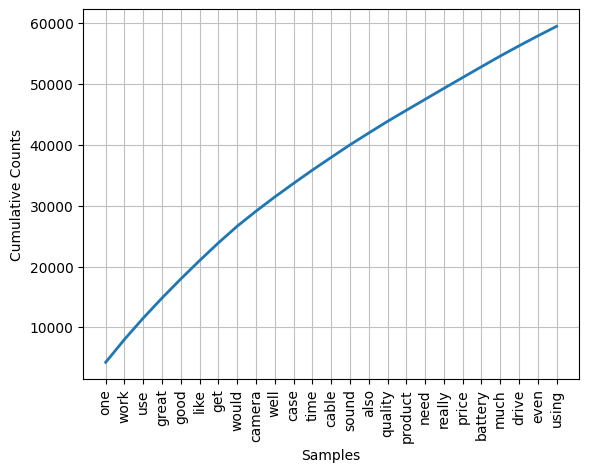

<Axes: xlabel='Samples', ylabel='Cumulative Counts'>

In [52]:
from nltk.probability import FreqDist
import matplotlib.pyplot as plt
import matplotlib as p
fd_1 = FreqDist()
for freq_token in unigram:
    fd_1.update(freq_token)
print(fd_1.most_common(100))
fd_1.plot(25, cumulative=True)

In [55]:
least_common = fd_1.most_common()[-50:]
review_df2 = review_df.copy()
total_count = len(review_df2)
rare_tokensSet = set()
less3_tokensSet = set()

for token, count in fd_1.items():
    frequency = count / total_count
    if frequency < 0.02:
        rare_tokensSet.add(token)
    elif frequency < 3:
        less3_tokensSet.add(token)

review_df2['review_text'] = review_df2['review_text'].apply(lambda x: [w for w in x if w not in rare_tokensSet])
review_df2['review_summary'] = review_df2['review_summary'].apply(lambda x: [w for w in x if w not in rare_tokensSet])
review_df2.to_csv("amazon-customer-reviews-nlp.csv", index = False)

In [ ]:
#Analysis

In [58]:
amazon_reviews = pd.read_csv("amazon-customer-reviews-nlp.csv")
amazon_reviews.head()

,userID,review_date,productID,review_helpful,review_text,review_summary
0,A1BWD4UA5QTBOI,2013-10-28,B004BQKQ8A,"[0, 0]","['card', 'work', 'expected', 'fast', 'great', ...","['bought', 'older', 'computer']"
1,A27JB8ALUWAECO,2014-01-16,B005O74J7O,"[0, 0]","['well', 'case', 'go', 'one', 'look', 'good', ...",[]
2,A32B6A532454UD,2012-06-12,B005P9CATU,"[10, 10]","['using', 'app', 'power', 'connector', 'year',...","['connector', 'standard', 'radio', 'us', '30']"
3,A225M3GAYN01IG,2011-04-10,B0023APPCI,"[1, 1]","['model', 'use', 'led', 'hd', 'tv', 'amazing',...","['great', 'sound', 'easy', 'set', 'look', 'ama..."
4,AX2F72W2O86WI,2012-06-07,B0055LGG3Y,"[3, 4]","['system', 'using', 'memory', 'system', 'purch...","['great', 'memory']"


In [59]:
from textblob import TextBlob
def analyse_sematic(text):
    words = word_tokenize(text)
    analysis = TextBlob("".join(words))
    sentiment = analysis.sentiment.polarity
    return sentiment
amazon_reviews['semantic_value_text'] = amazon_reviews['review_text'].apply(analyse_sematic)
amazon_reviews['semantic_value_summary'] = amazon_reviews['review_summary'].apply(analyse_sematic)
amazon_reviews.head()

,userID,review_date,productID,review_helpful,review_text,review_summary,semantic_value_text,semantic_value_summary
0,A1BWD4UA5QTBOI,2013-10-28,B004BQKQ8A,"[0, 0]","['card', 'work', 'expected', 'fast', 'great', ...","['bought', 'older', 'computer']",0.330000,0.166667
1,A27JB8ALUWAECO,2014-01-16,B005O74J7O,"[0, 0]","['well', 'case', 'go', 'one', 'look', 'good', ...",[],0.090278,0.000000
2,A32B6A532454UD,2012-06-12,B005P9CATU,"[10, 10]","['using', 'app', 'power', 'connector', 'year',...","['connector', 'standard', 'radio', 'us', '30']",0.132410,0.000000
3,A225M3GAYN01IG,2011-04-10,B0023APPCI,"[1, 1]","['model', 'use', 'led', 'hd', 'tv', 'amazing',...","['great', 'sound', 'easy', 'set', 'look', 'ama...",0.420000,0.558333
4,AX2F72W2O86WI,2012-06-07,B0055LGG3Y,"[3, 4]","['system', 'using', 'memory', 'system', 'purch...","['great', 'memory']",0.000000,0.800000


Evaluating our semantic analysis using Logistic Regression

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Assuming 'semantic_analysis' is the target variable
X = amazon_reviews['review_summary']
y = amazon_reviews['semantic_value_summary']

# Convert semantic values to classes (negative, neutral, positive)
y_classes = pd.cut(y, bins=[float('-inf'), 0.0, float('inf')], labels=['negative', 'positive'])

X_train, X_test, y_train, y_test = train_test_split(X, y_classes, test_size=0.3, random_state=42) # opted for 70% training, 30% valid.

vectorizer = TfidfVectorizer() # transform data into vectors
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

model = LogisticRegression() # apply LR model
model.fit(X_train_vec, y_train)

predictions = model.predict(X_test_vec)
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.978


In [87]:
# Assuming 'productID' is the column name
product_counts = amazon_reviews['productID'].value_counts()
# Find product IDs with more than one review
multiple_reviews_product_ids = product_counts[product_counts > 1].index.tolist()

# Choose the first product ID from the list for simplicity
selected_product_id = multiple_reviews_product_ids[0] if multiple_reviews_product_ids else None

if selected_product_id:
    print(f"Selected Product ID for Word Cloud: {selected_product_id}")
else:
    print("No product with multiple reviews found.")


Selected Product ID for Word Cloud: B007WTAJTO


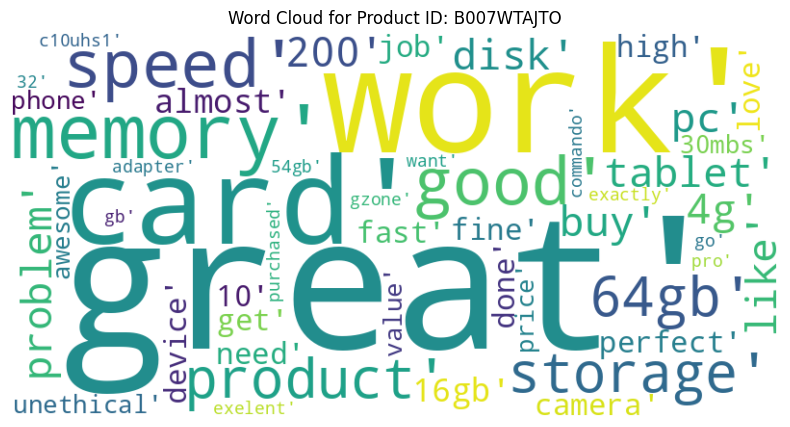

In [88]:
if selected_product_id:
    # Filter reviews for the selected product
    selected_product_reviews = amazon_reviews[amazon_reviews['productID'] == selected_product_id]
    # Concatenate all review summaries for this product
    aggregated_reviews = ' '.join(selected_product_reviews['review_summary'].astype(str))
from wordcloud import WordCloud
import matplotlib.pyplot as plt

if selected_product_id:
    # Generate and display the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(aggregated_reviews)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Word Cloud for Product ID: {selected_product_id}")
    plt.axis('off')
    plt.show()

